In [27]:
from dotenv import load_dotenv
import os
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

load_dotenv()


True

In [28]:
def get_llm():
    llm_type = os.getenv("LLM_TYPE", "ollama")
  
    if llm_type == "ollama":
        return ChatOllama(model="llama3.1:latest", temperature=0)
    else:
        return ChatOpenAI(temperature=0)


def get_embeddings():
    embedding_type = os.getenv("LLM_TYPE", "ollama")

    if embedding_type == "ollama":
        return OllamaEmbeddings(model="llama3.1:latest")
    else:
        return OpenAIEmbeddings()
    


### Create Vector DB

In [29]:
from langchain.schema import Document
from langchain_chroma import Chroma
from uuid import uuid4

embedding_function = get_embeddings()

docs = [
    Document(
        page_content=(
            "The iPhone 16, the latest innovation from Apple, introduces Apple Intelligence, harnessing advanced AI tools to enhance user productivity, creativity, and photography. Built with a focus on power and design, iPhone 16 features the A18 chip, a durable build, and comes in five vibrant colors. It offers users a sleek and immersive experience with a range of new features."
        ),
        metadata={"source": "about_iphone_16.txt"},
    ),
    Document(
        page_content=(
            "The iPhone 16 lineup offers a variety of options to suit diverse user preferences. Equipped with a new 48MP camera system featuring an Ultra Wide lens, it enables detailed photography. The inclusion of Apple’s Action button provides quick access to essential functions, enhancing user convenience and customization."
        ),
        metadata={"source": "features_and_camera.txt"},
    ),
    Document(
        page_content=(
            "Apple offers round-the-clock customer support for iPhone 16 users. Users can access a range of support services, from setup assistance to troubleshooting, ensuring a seamless experience. In addition, iOS 18 introduces satellite messaging for emergency connectivity, ensuring users can stay connected even in remote areas."
        ),
        metadata={"source": "support_and_services.txt"},
    ),
    Document(
        page_content=(
            "The iPhone 16 is engineered for durability and efficiency. Powered by the new A18 chip, it delivers enhanced performance and improved battery life. Its robust design, combined with innovative features like Apple Intelligence and satellite messaging, makes it a versatile tool for both everyday use and professional needs."
        ),
        metadata={"source": "product_specs.txt"},
    ),
]



#Chroma initialization
vector_store = Chroma(
    collection_name="app-document",
    embedding_function=embedding_function,
    persist_directory="chroma_db",  # Where to save data locally
)


uuids = [str(uuid4()) for _ in range(len(docs))]

#add the documents to the vector store
vector_store.add_documents(documents=docs, ids=uuids)

retriever = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={"k":2, "fetch_k": 4}
)

retriever.invoke("What new features does the iPhone 16 introduce?")



[Document(metadata={'source': 'about_iphone_16.txt'}, page_content='The iPhone 16, the latest innovation from Apple, introduces Apple Intelligence, harnessing advanced AI tools to enhance user productivity, creativity, and photography. Built with a focus on power and design, iPhone 16 features the A18 chip, a durable build, and comes in five vibrant colors. It offers users a sleek and immersive experience with a range of new features.'),
 Document(metadata={'source': 'about_iphone_16.txt'}, page_content='The iPhone 16, the latest innovation from Apple, introduces Apple Intelligence, harnessing advanced AI tools to enhance user productivity, creativity, and photography. Built with a focus on power and design, iPhone 16 features the A18 chip, a durable build, and comes in five vibrant colors. It offers users a sleek and immersive experience with a range of new features.')]

In [30]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    question: str
    grades: list[str]
    llm_output: list[str]
    documents: list[str]
    on_topic: bool

In [31]:
def retrieve_docs(state: AgentState):
    question = state['question']

    documents = retriever.get_relevant_documents(query=question)

    print("RETRIEVED DOCUMENTS: ", documents)

    state['documents'] = [doc.page_content for doc in documents]

    return state



In [32]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """ Boolean value to check whether a question is related to iPhone 16"""

    score: str = Field(
        description="Is the Question about iPhone 16? If yes -> 'Yes' if not -> 'No'"
    )


def question_classifier(state: AgentState):
    question  = state['question']

    system =  """
            You are a grader assessing the topic of a user question.
            
            Only answer if the question is about one of the following topics:
            1. About the iPhone 16.
            2. Features and Cameras of iPhone 16.
            3. Service and support for the iPhone 16.
            4. iPhone 16 product specifications.

            Example: How will the weather be today? -> No
                    What are the features of the iPhone 16? -> Yes
                    What services do you offer? -> No

            If the question IS about the topics, respond with "Yes", otherwise respond with "No".
        """
    
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

    llm = get_llm()
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({"question": question})
    print(f"QUESTION and GRADE: {question} - {result.score}")
    state["on_topic"] = result.score
    return state



In [33]:
def on_topic_router(state: AgentState):
    on_topic = state['on_topic']

    if on_topic.lower() == "yes":
        return "on_topic"
    else:
        return 'off_topic'


In [34]:
def off_topic_response(state: AgentState):
    print('=== OUT OF TOPIC QUESTION ====')
    state["llm_output"] = "I cant respond to that!"
    return state

In [35]:
class GradeDocuments(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(
        description = "Documents are relevant to the question, 'Yes' or 'No'"
    )

def document_grader(state: AgentState):
    docs = state['documents']
    question = state['question']

    system = """You are a grader assessing relevance of retrieved documents to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question.
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', system),
            ("human", "Retrieved document: \n\n {document} \n\n User question {question}")
        ]
    )

    llm = get_llm()
    structure_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structure_llm

    scores = []

    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        print(result)
        scores.append(result.score)
    state['grades'] = scores

    return state

In [36]:
def generate_router(state: AgentState):
    grades = state['grades']
    print("DOCUMENT GRADE: ", grades)

    if any(grade.lower() == 'yes' for grade in grades):
        filtered_grades = [grade for grade in grades if grade.lower() == "yes"]
        print("FILTERED DOCUMENT GRADES:", filtered_grades)
        return "generate"
    else:
        return "rewrite_query"

In [37]:
from langchain_core.output_parsers import StrOutputParser

def rewrite(state: AgentState):
    question  = state['question']
    
    system = """You are a question re-writer that converts an input question to a better version that is optimized \n
    for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
    """

    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question.")
        ]
    )

    llm = get_llm()
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({'question': question})

    state['question'] = output

    return state

In [38]:
from langchain_core.output_parsers import StrOutputParser

def generate_answer(state: AgentState):
    llm = get_llm()

    question = state['question']
    context = state['documents']

    template = """Answer the question based only on the following context: {context}
    
    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template
    )

    chain = prompt | llm | StrOutputParser()

    result = chain.invoke({'question': question, 'context': context})

    state['llm_output'] = result

    return state

In [39]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("document_grader", document_grader)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate_answer", generate_answer)

workflow.add_edge(START, 'question_classifier')
workflow.add_edge('question_classifier', END)


# Add edges to the workflow
workflow.add_edge(START, 'question_classifier')


workflow.add_conditional_edges('question_classifier',on_topic_router, {
    "off_topic": "off_topic_response",
    "on_topic": "retrieve_docs"
    
} )

workflow.add_edge('retrieve_docs', 'document_grader')

workflow.add_conditional_edges('document_grader', generate_router, {
    "generate": "generate_answer",
    "rewrite_query": "rewrite",
})


workflow.add_edge('rewrite', 'retrieve_docs')


workflow.add_edge('off_topic_response', END)
workflow.add_edge('generate_answer', END)



# Compile the workflow
app = workflow.compile()


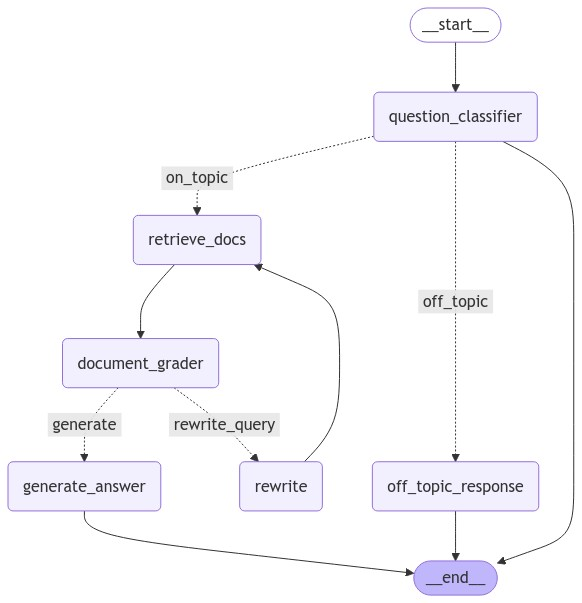

In [40]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [41]:
result = app.invoke({"question": "What new features does the iPhone 16 introduce?"})
result


QUESTION and GRADE: What new features does the iPhone 16 introduce? - What new features does the iPhone 16 introduce?
=== OUT OF TOPIC QUESTION ====


{'question': 'What new features does the iPhone 16 introduce?',
 'llm_output': 'I cant respond to that!',
 'on_topic': 'What new features does the iPhone 16 introduce?'}

In [42]:
result = app.invoke({"question": "What is the capital of kenya "})
result

QUESTION and GRADE: What is the capital of kenya  - No
=== OUT OF TOPIC QUESTION ====


{'question': 'What is the capital of kenya ',
 'llm_output': 'I cant respond to that!',
 'on_topic': 'No'}